# Models to predict the mortality of sepsis patients

In [55]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import datetime
from time import time
import import_ipynb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import visuals as vs

# Import supplementary visualization code visuals.py
import visuals as vs

## Extracting the clean data  

In [116]:
import os
os.getcwd()
os.chdir(r'C:\Users\skura\Desktop\HAP\Project')
labevents = pd.read_csv(r'clean_sepsis_feature_list.csv')

sepsis_features = pd.read_csv('clean_sepsis_feature_list.csv')

In [117]:
sepsis_features.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'Alanine Aminotransferase (ALT)',
       'Alkaline Phosphatase', 'Anion Gap', 'Asparate Aminotransferase (AST)',
       'Basophils', 'Bicarbonate', 'Bilirubin, Total', 'Calcium, Total',
       'Chloride', 'Creatinine', 'Eosinophils', 'Glucose', 'Hematocrit',
       'Hemoglobin', 'INR(PT)', 'Lactate', 'Lymphocytes', 'MCH', 'MCHC', 'MCV',
       'Magnesium', 'Monocytes', 'Neutrophils', 'PT', 'PTT', 'Phosphate',
       'Platelet Count', 'Potassium', 'RDW', 'Red Blood Cells', 'Sodium',
       'Specific Gravity', 'Urea Nitrogen', 'White Blood Cells', 'pH',
       'admission_type', 'insurance', 'ethnicity', 'death_period', 'gender',
       'age', 'BLOOD CULTURE', 'MRSA SCREEN', 'SPUTUM', 'STOOL', 'SWAB',
       'URINE', 'num_of_infections'],
      dtype='object')

In [118]:
sepsis_features.drop(['Unnamed: 0'],axis=1,inplace=True)

In [59]:
sepsis_features.head()

,subject_id,hadm_id,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",...,death_period,gender,age,BLOOD CULTURE,MRSA SCREEN,SPUTUM,STOOL,SWAB,URINE,num_of_infections
0,21,111970,47.000000,167.000000,17.0,82.000000,0.00,23.50,0.300000,7.700000,...,1,M,87,1,0,0,1,0,0,2
1,94,183686,90.333333,68.666667,14.0,82.333333,0.85,23.25,1.033333,8.075000,...,0,M,74,0,0,0,0,0,0,0
2,157,107880,13.000000,118.000000,17.4,25.000000,0.00,18.00,0.600000,7.940000,...,0,M,80,0,0,0,0,0,2,3
3,166,128219,94.822544,141.192150,19.0,148.710368,0.00,24.00,1.501629,7.903004,...,1,F,91,1,0,0,0,0,0,1
4,188,191517,121.000000,130.000000,15.0,114.000000,0.00,17.00,1.775000,7.725000,...,0,M,51,0,0,0,0,0,0,0


In [121]:
sepsis_features.num_of_infections.describe()

count    1178.000000
mean        1.224109
std         1.553037
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        14.000000
Name: num_of_infections, dtype: float64

### Analyzing the co-relation and importance of all features together

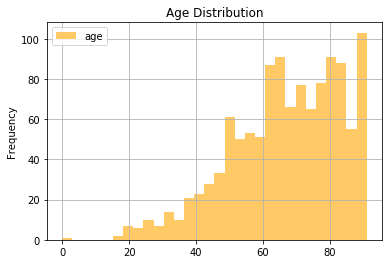

In [7]:
ax = sepsis_features[['age']].plot(kind='hist', title ="Age Distribution", legend=True, grid=True, bins=30, color='orange', alpha=0.6)

In [60]:
import seaborn as sns
sns.set(style='ticks')
sns.set_context("notebook", font_scale=1)
sns.set_style("darkgrid")
# Compute the correlation matrix
corr = sepsis_features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            #square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Visulaizing co-relation with the target

In [9]:
corr_with_target = corr['death_period']
corr_with_target = corr_with_target.reset_index()
corr_with_target.drop(corr_with_target.index[0:2],inplace=True)
corr_with_target.drop(corr_with_target.index[corr_with_target['index'] == 'death_period'],inplace=True)
corr_with_target.sort_values("death_period",inplace=True)

#f, ax = plt.subplots(figsize=(20, 15))
#f.autofmt_xdate(rotation=90)
#sns.barplot(x="index", y="death_period", data=corr_with_target,ax=ax)

In [10]:
### Values of co-relation with target
#corr_with_target.drop(corr_with_target.index[corr_with_target['index'] == 'death_period'])

In [11]:
## Squaring the value to list out top co-relation
X = corr_with_target.drop(corr_with_target.index[corr_with_target['index'] == 'death_period'])
X['death_period'] = X['death_period']**2
#X.sort_values(['death_period'],ascending=False)

### Prepare the data for machine learning models

Normalize the data such that all data points have same priorities

In [53]:
sepsis_features.shape

(1178, 50)

In [12]:
#sepsis_features.describe().T

In [71]:
numeric_data = sepsis_features.select_dtypes(include=[np.number])

In [72]:
numeric_data.columns
numeric_data.drop(['subject_id','hadm_id','death_period','num_of_infections','age'],axis=1,inplace=True)

In [73]:
numeric_data = sepsis_features.select_dtypes(include=[np.number])
potential_outliers = []
from collections import Counter
from IPython.display import display

# For each feature find the data points with extreme high or low values
for feature in numeric_data.columns:

    # Calculate Q1
    Q1 = np.percentile(sepsis_features[feature], 25)
    
    # Calculate Q3
    Q3 = np.percentile(sepsis_features[feature], 75)
    
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    outlier = sepsis_features[~((sepsis_features[feature] >= Q1 - step) & (sepsis_features[feature] <= Q3 + step))]
    potential_outliers += outlier.index.tolist()
    
print(potential_outliers)
len({k:v for (k,v) in Counter(potential_outliers).items() if v > 4})
#outliers = [k for (k,v) in Counter(potential_outliers).items() if v > 4]

[14, 17, 102, 127, 147, 148, 172, 205, 210, 222, 233, 256, 275, 281, 283, 285, 341, 351, 352, 359, 367, 371, 412, 436, 437, 453, 454, 466, 467, 488, 506, 532, 551, 575, 590, 603, 636, 637, 647, 659, 684, 693, 707, 722, 729, 744, 746, 789, 819, 827, 842, 851, 860, 866, 890, 892, 933, 934, 936, 944, 986, 1029, 1048, 1049, 1051, 1060, 1073, 1087, 1106, 1118, 1154, 12, 19, 38, 40, 43, 47, 56, 77, 92, 100, 107, 113, 121, 125, 129, 135, 139, 148, 167, 168, 169, 175, 177, 181, 196, 198, 200, 210, 237, 241, 249, 251, 269, 281, 300, 302, 307, 333, 341, 343, 359, 378, 379, 384, 385, 392, 402, 406, 439, 442, 493, 516, 531, 537, 544, 552, 557, 558, 581, 604, 609, 636, 637, 648, 664, 666, 676, 677, 683, 692, 703, 710, 714, 722, 733, 738, 739, 748, 752, 757, 760, 761, 762, 777, 792, 804, 831, 836, 845, 850, 856, 866, 875, 933, 936, 979, 981, 986, 993, 1002, 1024, 1039, 1043, 1048, 1049, 1050, 1052, 1064, 1069, 1073, 1074, 1104, 1124, 1165, 1176, 52, 77, 96, 101, 102, 121, 123, 165, 169, 191, 210, 21

176

#### Normalize the features

Since there are a lot of outliers,we are going to use Robustscaler to do the normalization

In [74]:
columns_to_normalize = sepsis_features.describe().columns.tolist()
columns_to_normalize.remove('subject_id')
columns_to_normalize.remove('hadm_id')
columns_to_normalize.remove('death_period')
columns_to_normalize.remove('age')

In [75]:
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
processed_sepsis_features = sepsis_features.copy()
processed_sepsis_features[columns_to_normalize] = scaler.fit_transform(sepsis_features[columns_to_normalize])
#processed_sepsis_features.describe().T

#### One hot encoding of all categorical features

In [76]:
processed_sepsis_features.select_dtypes(exclude=['floating','integer']).head()

,admission_type,insurance,ethnicity,gender
0,EMERGENCY,Medicare,WHITE,M
1,EMERGENCY,Medicare,ASIAN,M
2,EMERGENCY,Medicare,WHITE,M
3,EMERGENCY,Medicare,WHITE,F
4,EMERGENCY,Private,WHITE,M


In [77]:
processed_sepsis_features = pd.get_dummies(processed_sepsis_features)
print(len(processed_sepsis_features.columns))
#print(processed_sepsis_features.columns)

80


### Shuffle and Split Data

Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 90% of the data will be used for training and 10% for testing. We are doing 90% and 10% because our dataset is small.

In [78]:
# Import train_test_split
from sklearn.model_selection import train_test_split
#sklearn.model_selection.train_test_split

features = processed_sepsis_features.drop(['subject_id','hadm_id','death_period'],axis=1)
targets = processed_sepsis_features['death_period']

# Split the 'features' and  data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 942 samples.
Testing set has 236 samples.


In [79]:
y_train.shape

(942,)

##  from the data driven 

In [80]:
# Calculate accuracy
accuracy = len(targets[targets == 1])/float(len(targets))
# Calculate F-score using the formula above for beta = 0.5
fscore = (1 + 0.5**2)*(accuracy*1)/(((0.5**2)*accuracy) + 1)
# Print the results 
print("simple Predictor: [Accuracy: {:.4f}%, F-score: {:.4f}]".format(accuracy*100, fscore))

simple Predictor: [Accuracy: 21.3922%, F-score: 0.2538]


## Model Prediction

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


In [140]:
lr = LogisticRegression(solver='lbfgs', C=0.9, max_iter=1000)
lr.fit(X_train,y_train)



LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [141]:
probs = lr.predict_proba(X_test)[:,-1]
fpr,tpr,thresholds = roc_curve(y_test,probs)
auc(fpr,tpr)


0.691564863292612

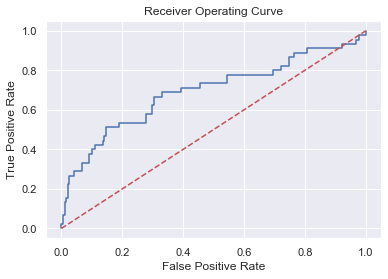

In [142]:

plt.figure()
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.show()


In [131]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [132]:
probs = rf.predict_proba(X_test)[:,-1]
fpr,tpr,thresholds = roc_curve(y_test,probs)
auc(fpr,tpr)

0.8075043630017451

In [145]:
cls = X_train.columns

In [146]:
cls

Index(['Alanine Aminotransferase (ALT)', 'Alkaline Phosphatase', 'Anion Gap',
       'Asparate Aminotransferase (AST)', 'Basophils', 'Bicarbonate',
       'Bilirubin, Total', 'Calcium, Total', 'Chloride', 'Creatinine',
       'Eosinophils', 'Glucose', 'Hematocrit', 'Hemoglobin', 'INR(PT)',
       'Lactate', 'Lymphocytes', 'MCH', 'MCHC', 'MCV', 'Magnesium',
       'Monocytes', 'Neutrophils', 'PT', 'PTT', 'Phosphate', 'Platelet Count',
       'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Specific Gravity',
       'Urea Nitrogen', 'White Blood Cells', 'pH', 'age', 'BLOOD CULTURE',
       'MRSA SCREEN', 'SPUTUM', 'STOOL', 'SWAB', 'URINE', 'num_of_infections',
       'admission_type_EMERGENCY', 'admission_type_URGENT',
       'insurance_Government', 'insurance_Medicaid', 'insurance_Medicare',
       'insurance_Private', 'insurance_Self Pay', 'ethnicity_ASIAN',
       'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN',
       'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - K

#### Sensivity Analysis

In [144]:
cnt1 = X_train[X_train['age']<20]
cnt2= X_train[X_train['age']>40]
cnt3= X_train[X_train['age']==30]
tr1 = pd.DataFrame()
tr1 = tr1.append(cnt1)
tr1 = tr1.append(cnt2)
tr1 = tr1.append(cnt3)


In [147]:
lr = LogisticRegression(solver='lbfgs', C=0.9, max_iter=1000)
lr.fit(tr1,y_train)
probs = lr.predict_proba(X_test)[:,-1]
fpr,tpr,thresholds = roc_curve(y_test,probs)
auc(fpr,tpr)

ValueError: Found input variables with inconsistent numbers of samples: [883, 942]

In [ ]:
lr = LogisticRegression(solver='lbfgs', C=0.9, max_iter=1000)
lr.fit(tr[cls],tr['HighUtilizationY2'])
acc = []
for cnt in range(0,300,10):
    tt = X_test[(X_test['age'] >= cnt) & (X_test['age'] < cnt + 10)]
    probs = lr.predict_proba(X_test)[:,-1]
    temp = accuracy_score(probs,tt['HighUtilizationY2'])
    print(temp)
    acc.append(temp)

In [138]:
dist = []
dist1 = []
for a in list(x):
    tt = X_test[X_test['age'] == a]
    ttt = X_train[X_train['age'] == a]
    dist.append( rf.predict_proba(tt[cls])[:,1].mean())
    dist1.append( rf.predict_proba(ttt[cls])[:,1].mean())
    

ValueError: Found array with 0 sample(s) (shape=(0, 77)) while a minimum of 1 is required.

In [ ]:
plt.plot(list(x),dist)
plt.plot(list(x),dist1)

In [89]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score,accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Training the Machine Learning Models

In [90]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


my_random_state=42

# Initialize the three models
clf_A = LogisticRegression(random_state=my_random_state)
clf_B = RandomForestClassifier(random_state=my_random_state)



# Calculate the number of samples for 50%, 70%, and 100% of the training data
samples_50 = int(0.5*len(X_train))
samples_70 = int(0.7*len(X_train))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_50, samples_70, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

LogisticRegression trained on 471 samples.
LogisticRegression trained on 659 samples.
LogisticRegression trained on 942 samples.
RandomForestClassifier trained on 471 samples.
RandomForestClassifier trained on 659 samples.
RandomForestClassifier trained on 942 samples.


#### **Combine all results together in a single dataset**

In [91]:
# This function takes a nested dictionary and flattens it
def flatten_dict(d):
    def items():
        for key, value in d.items():
            if isinstance(value, dict):
                for subkey, subvalue in flatten_dict(value).items():
                    yield str(key) + "." + str(subkey), subvalue
            else:
                yield key, value

    return dict(items())

In [94]:
#Merge results from all 3 tests into single dictionary and then flatten the dictionary
final_results = results.copy()
final_results = flatten_dict(final_results)

#Copy results into a dataframe for easier analysis of results
final_result_df = pd.DataFrame(columns=['model_name', 'iteration#'])
for key,value in final_results.items():
    key_split = key.split('.')
    final_result_df = final_result_df.append(pd.DataFrame([[key_split[0],key_split[1],value]],columns=['model_name', 'iteration#', key_split[2]] ))

final_result_df.set_index(['model_name'], inplace=True)
final_result_df.reset_index(inplace=True)

final_result_df = final_result_df.groupby(['model_name','iteration#']).mean()
final_result_df.reset_index(inplace=True)
final_result_df.sort_values(by=['f_test'],ascending=False)

,model_name,iteration#,acc_test,acc_train,f_test,f_train,pred_time,train_time
5,RandomForestClassifier,2,0.826271,0.993333,0.496454,0.993789,0.010738,0.066717
0,LogisticRegression,0,0.805085,0.870000,0.472637,0.735294,0.001663,0.009513
2,LogisticRegression,2,0.805085,0.846667,0.443787,0.661157,0.004001,0.031429
1,LogisticRegression,1,0.796610,0.853333,0.432432,0.675182,0.004063,0.007401
4,RandomForestClassifier,1,0.813559,0.996667,0.413223,0.988024,0.005254,0.020244
3,RandomForestClassifier,0,0.809322,0.986667,0.366972,0.987261,0.007377,0.014468


### Sensitivity Analysis

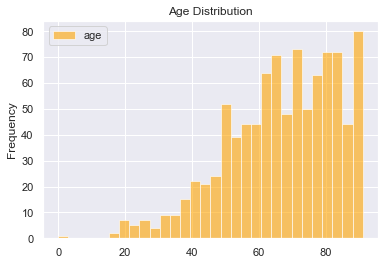

In [95]:
ax = X_train[['age']].plot(kind='hist', title ="Age Distribution", legend=True, grid=True, bins=30, color='orange', alpha=0.6)

In [ ]:
x =

In [86]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as skpp
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

param_grid = {
              "n_estimators": list(range(1,100)),
             }

forest = RandomForestClassifier( random_state=42)

In [87]:
rand_for = RandomizedSearchCV(forest, param_grid, scoring = 'roc_auc', n_iter=20, random_state=42)
_ = rand_for.fit(X_train, y_train)

In [88]:
print(rand_for.best_score_)
print(rand_for.best_params_)
print(rand_for.best_estimator_)

0.7970028591146604
{'n_estimators': 98}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=98,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [43]:
importances = rand_for.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("{}) {} {}".format(f,X_train.columns[indices[f]], importances[indices[f]]))

0) Lactate 0.07285140700061678
1) Phosphate 0.05995472667253431
2) Anion Gap 0.049994711707884526
3) Bicarbonate 0.04605386283546332
4) PTT 0.0380745956544958
5) Urea Nitrogen 0.03579905765035702
6) Calcium, Total 0.03221803668908821
7) MCHC 0.031378759747766855
8) age 0.0273785651957938
9) Hematocrit 0.027184805934324777
10) Monocytes 0.026333883248864234
11) Neutrophils 0.026154524019653118
12) Sodium 0.025119751069508874
13) MCH 0.02508792452689345
14) White Blood Cells 0.024802415832972952
15) PT 0.024563302972316705
16) Magnesium 0.02447940611623975
17) MCV 0.02381213290266255
18) Glucose 0.023591583362583133
19) Potassium 0.023109707264562566
20) RDW 0.022966562268280373
21) Asparate Aminotransferase (AST) 0.022294953054167108
22) Platelet Count 0.021342113798778695
23) INR(PT) 0.021003287016500685
24) Chloride 0.020566998139367663
25) Lymphocytes 0.020530214865564483
26) Bilirubin, Total 0.02008915346570599
27) Alkaline Phosphatase 0.019886651235965582
28) Red Blood Cells 0.0190

In [44]:
importances

array([1.54346073e-02, 1.98866512e-02, 4.99947117e-02, 2.22949531e-02,
       1.14649996e-02, 4.60538628e-02, 2.00891535e-02, 3.22180367e-02,
       2.05669981e-02, 1.85885706e-02, 1.11537220e-02, 2.35915834e-02,
       2.71848059e-02, 1.88717490e-02, 2.10032870e-02, 7.28514070e-02,
       2.05302149e-02, 2.50879245e-02, 3.13787597e-02, 2.38121329e-02,
       2.44794061e-02, 2.63338832e-02, 2.61545240e-02, 2.45633030e-02,
       3.80745957e-02, 5.99547267e-02, 2.13421138e-02, 2.31097073e-02,
       2.29665623e-02, 1.90790902e-02, 2.51197511e-02, 1.46112308e-02,
       3.57990577e-02, 2.48024158e-02, 7.63877276e-03, 2.73785652e-02,
       2.55107297e-03, 8.12126118e-04, 4.84076267e-03, 1.26804275e-03,
       2.36055711e-03, 2.43677334e-03, 7.09241135e-03, 4.15896212e-04,
       7.65237259e-04, 1.83650311e-04, 9.70108462e-04, 3.26878836e-03,
       2.12187423e-03, 3.31509529e-04, 2.61319483e-04, 4.72200775e-05,
       1.04913773e-04, 1.84969351e-03, 0.00000000e+00, 0.00000000e+00,
      

In [51]:
X_train.columns

Index(['Alanine Aminotransferase (ALT)', 'Alkaline Phosphatase', 'Anion Gap',
       'Asparate Aminotransferase (AST)', 'Basophils', 'Bicarbonate',
       'Bilirubin, Total', 'Calcium, Total', 'Chloride', 'Creatinine',
       'Eosinophils', 'Glucose', 'Hematocrit', 'Hemoglobin', 'INR(PT)',
       'Lactate', 'Lymphocytes', 'MCH', 'MCHC', 'MCV', 'Magnesium',
       'Monocytes', 'Neutrophils', 'PT', 'PTT', 'Phosphate', 'Platelet Count',
       'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Specific Gravity',
       'Urea Nitrogen', 'White Blood Cells', 'pH', 'age', 'BLOOD CULTURE',
       'MRSA SCREEN', 'SPUTUM', 'STOOL', 'SWAB', 'URINE', 'num_of_infections',
       'admission_type_EMERGENCY', 'admission_type_URGENT',
       'insurance_Government', 'insurance_Medicaid', 'insurance_Medicare',
       'insurance_Private', 'insurance_Self Pay', 'ethnicity_ASIAN',
       'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN',
       'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - K

In [52]:
x = X_train['num_of_infections'].unique()
x.sort()
x

array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,
        5. ,  6.5])